In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 19.3 MB/s eta 0:00:00


In [ ]:

# Standard library imports
import os
import sys
import json
import pickle
import random
import re
from glob import glob
from pathlib import Path

# Third-party library imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import scipy

# PyTorch imports
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# torchvision imports
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import VisionDataset
import torchvision.transforms as T

# PIL imports
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score
import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/dermoscopic_artifacts')
sys.path.append('/content/drive/MyDrive/dermoscopic_artifacts')
import importlib
import datasets
importlib.reload(datasets)
from datasets import ISICDataset, HAM10000Dataset, PH2Dataset, BCN20000Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ISIC melanoma classification model - ResNet-34


In [ ]:
import kagglehub
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'isic2018-challenge-task1-data-segmentation' dataset.
Path to dataset files: /kaggle/input/isic2018-challenge-task1-data-segmentation


In [ ]:
# Define paths
image_dir = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
mask_dir = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"

# Create dataset instances for each mode
dataset_modes = ["whole", "lesion", "background", "bbox", "bbox70", "bbox90",
                 "high_whole", "low_whole", "high_lesion", "low_lesion", "high_background", "low_background"]


In [ ]:
test_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg"
print("exists:", os.path.exists(test_path))

img = cv2.imread(test_path, cv2.IMREAD_COLOR)
print("img is None:", img is None)
if img is not None:
    print("shape:", img.shape)

exists: True
img is None: False
shape: (767, 1022, 3)


<PIL.Image.Image image mode=RGB size=1022x767 at 0x7E6E7283BAD0>


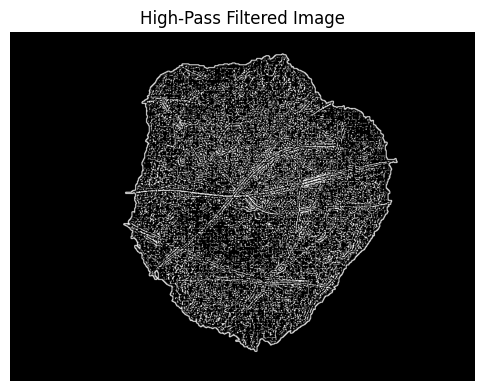

In [ ]:
high_pass_img = dataset[2][0]
print(high_pass_img)
high_pass_array = np.array(high_pass_img).astype(np.float32)  # Convert to float for scaling

# Normalize for visualization
high_pass_array = (high_pass_array - high_pass_array.min()) / (high_pass_array.max() - high_pass_array.min()) * 255
high_pass_array = high_pass_array.astype(np.uint8)  # Convert back to 8-bit

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(high_pass_array)
plt.axis("off")
plt.title("High-Pass Filtered Image")
plt.show()

In [ ]:
dataloader = DataLoader(ISICDataset(df, image_dir, mask_dir, mode="whole"), batch_size=16, shuffle=True)

In [ ]:
# Device configuration

# Training hyperparameters
num_epochs = 10  # Adjust as needed
learning_rate = 1e-4
batch_size = 32


# Select dataset mode (e.g., "whole", "lesion", etc.)
dataset_mode = "whole"  # Change this to your desired mode

# Create a directory to save models
save_dir = f"/content/drive/MyDrive/dermoscopic_artifacts/ablation_classifiers/{dataset_mode}"
os.makedirs(save_dir, exist_ok=True)

# Load dataset for this split
full_dataset = ISICDataset(df, image_dir, mask_dir, transform=transform, mode=dataset_mode, return_pil=False)

# Loop through each split (split_1 to split_5)
for split in range(1, 6):
    print(f"Training on {dataset_mode} - Split {split}")

    train_indices = df[df[f"split_{split}"] == "train"].index.tolist()
    test_indices = df[df[f"split_{split}"] == "test"].index.tolist()

    # Create subset datasets
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load pre-trained ResNet50
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

    # Modify the final layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1),
        nn.Sigmoid()
    )

    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        print(f"Starting epoch {epoch}")
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Ensure labels are (batch, 1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Save the trained model for this split - code typo this should say resnet34 as the output path
    model_path = f"{save_dir}/resnet50_split_{split}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

print("Training completed for all splits!")

Training on whole - Split 1
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 293MB/s]


Starting epoch 0


100%|██████████| 65/65 [06:17<00:00,  5.80s/it]


Epoch [1/10], Loss: 0.5559
Starting epoch 1


100%|██████████| 65/65 [05:38<00:00,  5.21s/it]


Epoch [2/10], Loss: 0.2351
Starting epoch 2


100%|██████████| 65/65 [05:36<00:00,  5.18s/it]


Epoch [3/10], Loss: 0.0975
Starting epoch 3


100%|██████████| 65/65 [05:36<00:00,  5.17s/it]


Epoch [4/10], Loss: 0.0899
Starting epoch 4


100%|██████████| 65/65 [05:38<00:00,  5.21s/it]


Epoch [5/10], Loss: 0.1084
Starting epoch 5


100%|██████████| 65/65 [05:37<00:00,  5.19s/it]


Epoch [6/10], Loss: 0.0544
Starting epoch 6


100%|██████████| 65/65 [05:34<00:00,  5.14s/it]


Epoch [7/10], Loss: 0.0249
Starting epoch 7


100%|██████████| 65/65 [05:35<00:00,  5.16s/it]


Epoch [8/10], Loss: 0.0275
Starting epoch 8


100%|██████████| 65/65 [05:36<00:00,  5.18s/it]


Epoch [9/10], Loss: 0.0181
Starting epoch 9


100%|██████████| 65/65 [05:36<00:00,  5.17s/it]


Epoch [10/10], Loss: 0.0236
Model saved to /content/drive/MyDrive/dermoscopic_artifacts/ablation_classifiers/whole/resnet50_split_1.pth
Training on whole - Split 2
Starting epoch 0


100%|██████████| 65/65 [05:50<00:00,  5.39s/it]


Epoch [1/10], Loss: 0.4364
Starting epoch 1


100%|██████████| 65/65 [05:39<00:00,  5.22s/it]


Epoch [2/10], Loss: 0.1896
Starting epoch 2


100%|██████████| 65/65 [05:41<00:00,  5.25s/it]


Epoch [3/10], Loss: 0.1096
Starting epoch 3


100%|██████████| 65/65 [05:42<00:00,  5.26s/it]


Epoch [4/10], Loss: 0.0739
Starting epoch 4


100%|██████████| 65/65 [05:42<00:00,  5.27s/it]


Epoch [5/10], Loss: 0.0732
Starting epoch 5


100%|██████████| 65/65 [05:39<00:00,  5.23s/it]


Epoch [6/10], Loss: 0.0403
Starting epoch 6


100%|██████████| 65/65 [05:39<00:00,  5.23s/it]


Epoch [7/10], Loss: 0.0616
Starting epoch 7


100%|██████████| 65/65 [05:39<00:00,  5.22s/it]


Epoch [8/10], Loss: 0.0259
Starting epoch 8


100%|██████████| 65/65 [05:39<00:00,  5.22s/it]


Epoch [9/10], Loss: 0.0206
Starting epoch 9


100%|██████████| 65/65 [05:40<00:00,  5.23s/it]


Epoch [10/10], Loss: 0.0197
Model saved to /content/drive/MyDrive/dermoscopic_artifacts/ablation_classifiers/whole/resnet50_split_2.pth
Training on whole - Split 3
Starting epoch 0


100%|██████████| 65/65 [05:42<00:00,  5.27s/it]


Epoch [1/10], Loss: 0.5254
Starting epoch 1


100%|██████████| 65/65 [05:38<00:00,  5.20s/it]


Epoch [2/10], Loss: 0.2341
Starting epoch 2


100%|██████████| 65/65 [05:41<00:00,  5.26s/it]


Epoch [3/10], Loss: 0.1215
Starting epoch 3


100%|██████████| 65/65 [05:41<00:00,  5.25s/it]


Epoch [4/10], Loss: 0.0638
Starting epoch 4


100%|██████████| 65/65 [05:39<00:00,  5.23s/it]


Epoch [5/10], Loss: 0.0781
Starting epoch 5


100%|██████████| 65/65 [05:40<00:00,  5.23s/it]


Epoch [6/10], Loss: 0.0549
Starting epoch 6


100%|██████████| 65/65 [05:40<00:00,  5.23s/it]


Epoch [7/10], Loss: 0.0332
Starting epoch 7


100%|██████████| 65/65 [05:40<00:00,  5.24s/it]


Epoch [8/10], Loss: 0.0335
Starting epoch 8


100%|██████████| 65/65 [05:41<00:00,  5.26s/it]


Epoch [9/10], Loss: 0.0288
Starting epoch 9


100%|██████████| 65/65 [05:40<00:00,  5.24s/it]


Epoch [10/10], Loss: 0.0388
Model saved to /content/drive/MyDrive/dermoscopic_artifacts/ablation_classifiers/whole/resnet50_split_3.pth
Training on whole - Split 4
Starting epoch 0


100%|██████████| 65/65 [05:43<00:00,  5.28s/it]


Epoch [1/10], Loss: 0.4718
Starting epoch 1


100%|██████████| 65/65 [05:41<00:00,  5.25s/it]


Epoch [2/10], Loss: 0.2055
Starting epoch 2


100%|██████████| 65/65 [05:41<00:00,  5.25s/it]


Epoch [3/10], Loss: 0.0911
Starting epoch 3


100%|██████████| 65/65 [05:43<00:00,  5.28s/it]


Epoch [4/10], Loss: 0.0673
Starting epoch 4


100%|██████████| 65/65 [05:43<00:00,  5.29s/it]


Epoch [5/10], Loss: 0.0841
Starting epoch 5


100%|██████████| 65/65 [05:44<00:00,  5.30s/it]


Epoch [6/10], Loss: 0.0613
Starting epoch 6


100%|██████████| 65/65 [05:42<00:00,  5.27s/it]


Epoch [7/10], Loss: 0.0312
Starting epoch 7


100%|██████████| 65/65 [05:41<00:00,  5.26s/it]


Epoch [8/10], Loss: 0.0182
Starting epoch 8


100%|██████████| 65/65 [05:40<00:00,  5.24s/it]


Epoch [9/10], Loss: 0.0191
Starting epoch 9


100%|██████████| 65/65 [05:45<00:00,  5.31s/it]


Epoch [10/10], Loss: 0.0544
Model saved to /content/drive/MyDrive/dermoscopic_artifacts/ablation_classifiers/whole/resnet50_split_4.pth
Training on whole - Split 5
Starting epoch 0


100%|██████████| 65/65 [05:43<00:00,  5.28s/it]


Epoch [1/10], Loss: 0.4508
Starting epoch 1


100%|██████████| 65/65 [05:43<00:00,  5.29s/it]


Epoch [2/10], Loss: 0.2205
Starting epoch 2


100%|██████████| 65/65 [05:42<00:00,  5.27s/it]


Epoch [3/10], Loss: 0.1060
Starting epoch 3


100%|██████████| 65/65 [05:44<00:00,  5.30s/it]


Epoch [4/10], Loss: 0.0604
Starting epoch 4


100%|██████████| 65/65 [05:43<00:00,  5.28s/it]


Epoch [5/10], Loss: 0.0546
Starting epoch 5


100%|██████████| 65/65 [05:41<00:00,  5.26s/it]


Epoch [6/10], Loss: 0.0594
Starting epoch 6


100%|██████████| 65/65 [05:41<00:00,  5.26s/it]


Epoch [7/10], Loss: 0.0745
Starting epoch 7


100%|██████████| 65/65 [05:43<00:00,  5.28s/it]


Epoch [8/10], Loss: 0.0568
Starting epoch 8


100%|██████████| 65/65 [05:42<00:00,  5.27s/it]


Epoch [9/10], Loss: 0.0216
Starting epoch 9


100%|██████████| 65/65 [05:40<00:00,  5.24s/it]

Epoch [10/10], Loss: 0.0251
Model saved to /content/drive/MyDrive/dermoscopic_artifacts/ablation_classifiers/whole/resnet50_split_5.pth
Training completed for all splits!
